In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import r2_score

from utils import scatter_plot, scatter_plot2
from dataset import NASBench101Dataset

In [15]:
#dataset = NASBench101Dataset('data/nasbench.hdf5', "860")
#dataset_test = NASBench101Dataset('data/nasbench.hdf5', "all")
dataset = NASBench101Dataset('data/nasbench.hdf5', "denoise-91")
#dataset_test = NASBench101Dataset('data/nasbench.hdf5')
dataset_size = len(dataset)

Here I get


In [16]:
features_flat = np.array(list(dataset.get_flat_features()))
targets = np.array(list(dataset.get_targets()))

# Print min value in targets
print("Min value in targets: {}".format(np.min(NASBench101Dataset.denormalize(targets))))

Min value in targets: 0.9100561141967773


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_flat, targets, test_size=0.4, random_state=42)

In [18]:
print([NASBench101Dataset.denormalize(t) for t in y_train[:10]])

[0.9244791865348816, 0.9197716116905212, 0.9116586446762085, 0.9155648946762085, 0.9229767918586731, 0.9200721383094788, 0.9304887652397156, 0.9275841116905212, 0.9265825152397156, 0.9237780570983887]


In [19]:
# Print number of y_test values in range 0.92-0.93
print("Number of y_test values in range 0.92-0.93: {}/{}".format(len([t for t in y_test if 0.92 <= NASBench101Dataset.denormalize(t) <= 0.93]), len(y_test)))

# Print number of y_train values in range 0.92-0.93
print("Number of y_train values in range 0.92-0.93: {}/{}".format(len([t for t in y_train if 0.92 <= NASBench101Dataset.denormalize(t) <= 0.93]), len(y_train)))

Number of y_test values in range 0.92-0.93: 32806/92207
Number of y_train values in range 0.92-0.93: 48909/138309


In [20]:
from random_forest import RFPredictor

rf_predictor = RFPredictor()

rf_predictor.fit(X_train, y_train)

y_pred = rf_predictor.query(X_test)

In [21]:
from xgb import XGBPredictor 

xgb_predictor = XGBPredictor()

xgb_predictor.fit(X_train, y_train)

y_pred = xgb_predictor.query(X_test)

In [23]:
# Print number of y_pred values in range 0.92-0.93
print("Number of y_pred values in range 0.92-0.93: {}/{}".format(len([t for t in y_pred if 0.92 <= NASBench101Dataset.denormalize(t) <= 0.93]), len(y_pred)))

Number of y_pred values in range 0.92-0.93: 92143/92207


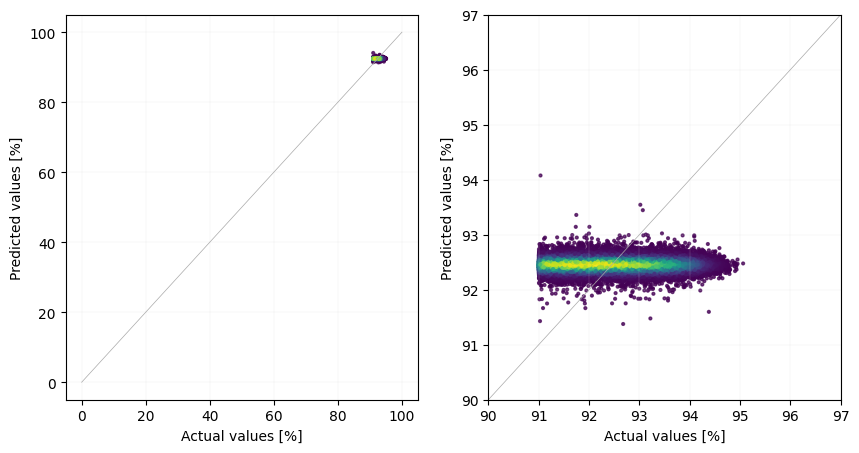

In [22]:
y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100 
y_pred_scaled = NASBench101Dataset.denormalize(y_pred) * 100

# PLot 
scatter_plot2(y_test_scaled, y_pred_scaled, dense=True)

In [7]:
import time

# Perform hyperparameter optimization using cross-validation
start_time = time.time()
best_hyperparams, best_cv_score = rf_predictor.run_hpo(
    xtrain=X_train,
    ytrain=y_train,
    train_info=None,  # or provide train_info if needed
    start_time=start_time,
    metric="kendalltau",
    max_iters=5000,
)

# Fit the predictor with the best hyperparameters found
rf_predictor.fit(X_train, y_train)

# Use the fitted predictor to make predictions on new data
# X_test: your test input data
y_pred = rf_predictor.query(X_test)

# Evaluate the predictor on the test set
metrics = rf_predictor.evaluate(X_test, y_test)
metrics["cv_score"] = best_cv_score
print("Cross validation score:", best_cv_score)
print("Metrics: ", metrics)

Starting cross validation
[0/5000] cv_score=-0.0005, params={'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}
--> new best score = 0, hparams = {'n_estimators': 116, 'max_features': 0.17055852159745608, 'min_samples_leaf': 2, 'min_samples_split': 2, 'bootstrap': False}
patience = 0/50
[1/5000] cv_score=-0.0006, params={'n_estimators': 77, 'max_features': 0.5029098999863144, 'min_samples_leaf': 12, 'min_samples_split': 14, 'bootstrap': False}
patience = 1/50
[2/5000] cv_score=-0.0005, params={'n_estimators': 42, 'max_features': 0.1298147832695397, 'min_samples_leaf': 9, 'min_samples_split': 17, 'bootstrap': False}
patience = 2/50
[3/5000] cv_score=-0.0006, params={'n_estimators': 20, 'max_features': 0.38653544214521374, 'min_samples_leaf': 13, 'min_samples_split': 9, 'bootstrap': False}
patience = 3/50


KeyboardInterrupt: 

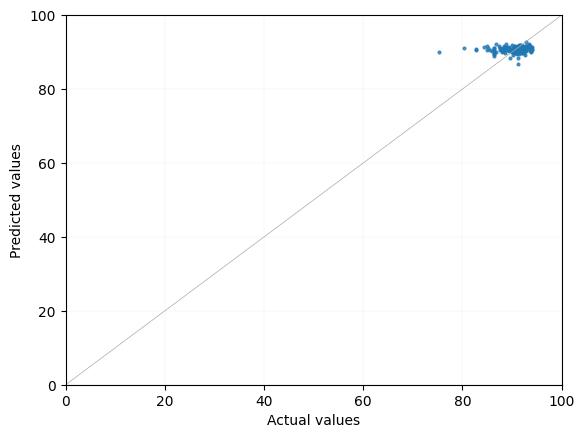

In [8]:
y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100
y_pred_scaled = NASBench101Dataset.denormalize(y_pred) * 100
# PLot the predictions
scatter_plot(y_test_scaled, y_pred_scaled)

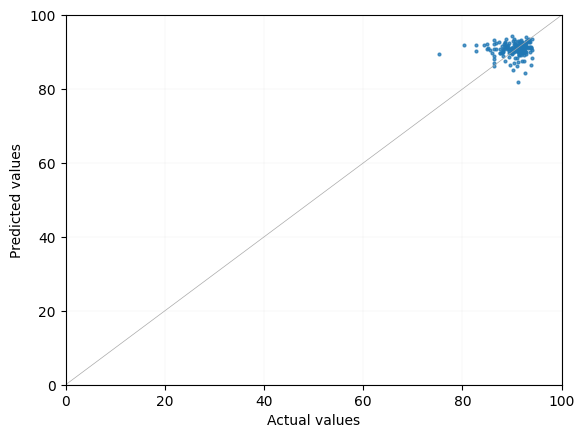

In [21]:
from xgb import XGBPredictor

model = XGBPredictor() 

model.fit(X_train, y_train)
y_pred = model.query(X_test)

y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100
y_pred_scaled = NASBench101Dataset.denormalize(y_pred) * 100
# Plot the results
scatter_plot(y_test_scaled, y_pred_scaled, "XGBoost")

In [5]:
def encode_adj(spec):
    """
    ADJACENCY_ONE_HOT: compute adjacency matrix + op list encoding
    """
    CONV1X1 = 1
    CONV3X3 = 0
    MAXPOOL3X3 = 2
    matrix, ops = spec["matrix"], spec["ops"]
    op_dict = {CONV1X1: [0, 0, 1], CONV3X3: [0, 1, 0], MAXPOOL3X3: [1, 0, 0]}
    encoding = []
    for i in range(NUM_VERTICES - 1):
        for j in range(i + 1, NUM_VERTICES):
            encoding.append(matrix[i][j])
    for i in range(1, NUM_VERTICES - 1): # skip input and output
        if ops[i] == -2 or ops[i] == -1:
            encoding = [*encoding, 0, 0, 0] # pad with zeros
        encoding = [*encoding, *op_dict[ops[i]]]
    return encoding

In [4]:
LABEL2ID = {
    "input": -1,
    "output": -2,
    "conv3x3-bn-relu": 0,
    "conv1x1-bn-relu": 1,
    "maxpool3x3": 2
}

In [ ]:
OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
OPS_INCLUSIVE = [INPUT, OUTPUT, *OPS]

NUM_VERTICES = 7
OP_SPOTS = NUM_VERTICES - 2
MAX_EDGES = 9

def encode_adj(spec):
    """
    ADJACENCY_ONE_HOT: compute adjacency matrix + op list encoding
    """
    matrix, ops = spec["matrix"], spec["ops"]
    op_dict = {CONV1X1: [0, 0, 1], CONV3X3: [0, 1, 0], MAXPOOL3X3: [1, 0, 0]}
    encoding = []
    for i in range(NUM_VERTICES - 1):
        for j in range(i + 1, NUM_VERTICES):
            encoding.append(matrix[i][j])
    for i in range(1, NUM_VERTICES - 1): # skip input and output
        encoding = [*encoding, *op_dict[ops[i]]]
    return encoding

def encode_gcn(spec):
    """
    Input:
    GCN: a list of categorical ops starting from 0
    """
    matrix, ops = spec["matrix"], spec["ops"]
    op_map = [OUTPUT, INPUT, *OPS]
    ops_onehot = np.array(
        [[i == op_map.index(op) for i in range(len(op_map))] for op in ops],
        dtype=np.float32,
    )

    dic = {
        "num_vertices": 7,
        "adjacency": matrix,
        "operations": ops_onehot,
        "mask": np.array([i < 7 for i in range(7)], dtype=np.float32),
        "val_acc": 0.0,
    }
    return dic

In [3]:
val_accs = np.zeros(dataset_size)
test_accs = np.zeros(dataset_size)
weights = np.zeros(dataset_size)

for i in range(dataset_size):
    sample = dataset[i]
    val_accs[i] = sample['val_acc']
    test_accs[i] = sample['test_acc']
    weights[i] = sample['trainable_parameters']

In [8]:
# Get test val_accs, and weights
val_accs_test = np.zeros(len(dataset_test))
weights_test = np.zeros(len(dataset_test))

for i in range(len(dataset_test)):
    sample = dataset_test[i]
    val_accs_test[i] = sample['val_acc']
    weights_test[i] = sample['trainable_parameters']

NameError: name 'dataset_test' is not defined

### Encoding

**flattening + one-hot encoding**

In [4]:
adj_matrices = np.zeros((dataset_size, 7, 7))
ops = np.zeros((dataset_size, 7, 5))

features = []

for i in range(dataset_size):
    
    # Adjacency and operations should be one-hot encoded already
    arch = dataset[i]
    adj_matrices[i] = arch["adjacency"][0] # TODO: why [0], because it is a list
    ops[i] = arch["operations_onehot"]
    
    # Flatten and concatenate
    adj_flat = adj_matrices[i].flatten()
    ops_flat = ops[i].flatten()
    
    f = np.concatenate((adj_flat, ops_flat))
    features.append(f)
    
    # TODO: weights?
    # nb101_features.append(arch["trainable_parameters"])
    
features = np.array(features)

In [13]:
# Get test features
features_test = []
adj_matrices = np.zeros((len(dataset_test), 7, 7))
ops = np.zeros((len(dataset_test), 7, 5))

for i in range(len(dataset_test)):
        
        # Adjacency and operations should be one-hot encoded already
        arch = dataset_test[i]
        adj_matrices[i] = arch["adjacency"][0]
        ops[i] = arch["operations"]
        
        # Flatten and concatenate
        adj_flat = adj_matrices[i].flatten()
        ops_flat = ops[i].flatten()
        
        f = np.concatenate((adj_flat, ops_flat))
        features_test.append(f)
        
features_test = np.array(features_test)

ValueError: could not broadcast input array from shape (7,) into shape (7,5)

### Divide into train and test set

maybe does not make sense to do it here (already done?)

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = features
y = val_accs

# Split into train and test
# TODO: beware of test_size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### XGBPredictor

In [9]:
from xgb import XGBPredictor

In [10]:
xgb_predictor = XGBPredictor()

### Cross-validation

In [12]:
import time

# Perform hyperparameter optimization using cross-validation
start_time = time.time()
best_hyperparams, best_cv_score = xgb_predictor.run_hpo(
    xtrain=X_train,
    ytrain=y_train,
    train_info=None,  # or provide train_info if needed
    start_time=start_time,
    metric="kendalltau",
    max_iters=5000,
)

# Fit the predictor with the best hyperparameters found
xgb_predictor.fit(X_train, y_train)

# Use the fitted predictor to make predictions on new data
# X_test: your test input data
y_pred = xgb_predictor.query(X_test)

# Evaluate the predictor on the test set
metrics = xgb_predictor.evaluate(X_test, y_test)
metrics["cv_score"] = best_cv_score
print("Cross validation score:", best_cv_score)
print("Metrics: ", metrics)

Starting cross validation
[0/5000] cv_score=0.0335, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.19926676628011908, 'learning_rate': 0.010292810564643255, 'colsample_bylevel': 0.13230493005214294}
--> new best score = 0.03349497406344761, hparams = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 5, 'min_child_weight': 1, 'colsample_bytree': 0.19926676628011908, 'learning_rate': 0.010292810564643255, 'colsample_bylevel': 0.13230493005214294}
patience = 0/50
[1/5000] cv_score=0.0335, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'max_depth': 14, 'min_child_weight': 8, 'colsample_bytree': 0.4673805912875204, 'learning_rate': 0.17724428389347482, 'colsample_bylevel': 0.02370941060139875}
patience = 1/50
[2/5000] cv_score=0.0335, params={'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree

In [13]:
# Fit the predictor with the best hyperparameters found
xgb_predictor.fit(X_train, y_train)

0.17676655838572894

In [14]:
predictions = xgb_predictor.query(X_test)
metrics = xgb_predictor.evaluate(X_test, y_test)
print("Metrics: ", metrics)

Metrics:  {'mae': 0.9368073155016311, 'rmse': 1.3213619422482583, 'pearson': 0.07386788532264645, 'spearman': 0.1143027118002669, 'kendalltau': 0.07508256351341698, 'r2_score': -0.3681381263443695}


In [15]:
actual = NASBench101Dataset.denormalize(y_test) * 100
predicted = NASBench101Dataset.denormalize(predictions) * 100

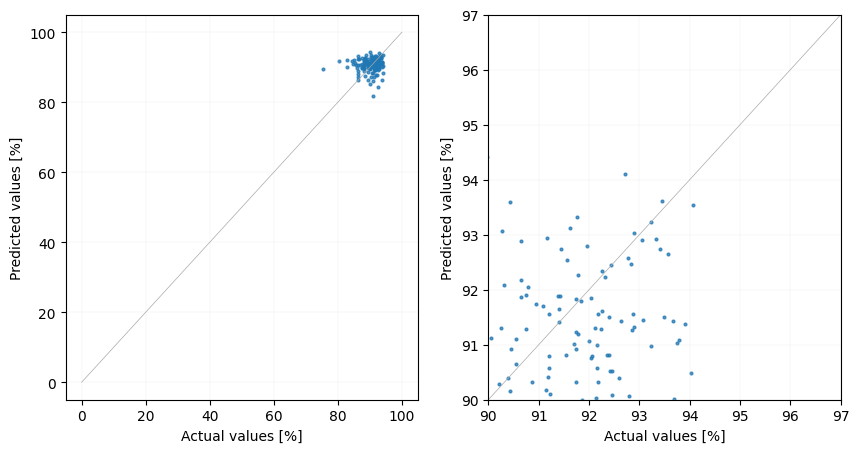

In [16]:
# Plot predictions vs ground truth
scatter_plot2(actual, predicted)

### Random Forest

In [15]:
from random_forest import RFPredictor

In [16]:
rf_predictor = RFPredictor()

In [17]:
# Fit the predictor
rf_predictor.fit(X_train, y_train)

0.13998621318443114

In [18]:
# Use the fitted predictor to make predictions on new data
rf_predictions = rf_predictor.query(X_test)
rf_metrics = rf_predictor.evaluate(X_test, y_test)

rf_predictions_scaled = NASBench101Dataset.denormalize(rf_predictions) * 100
y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100

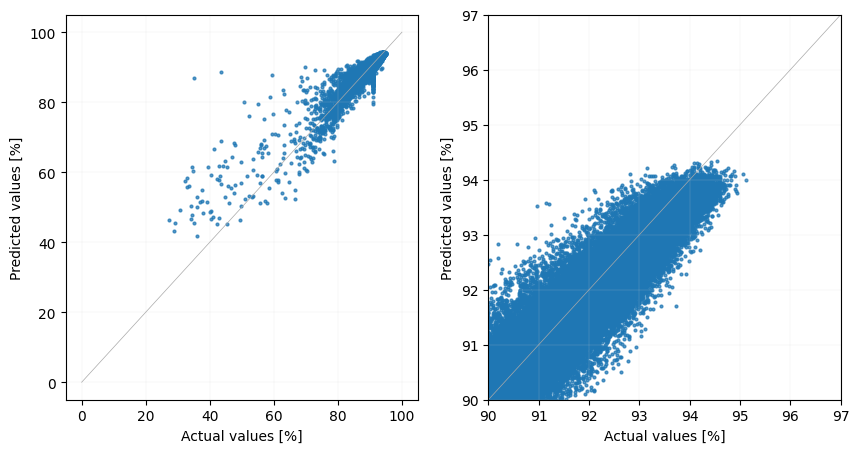

In [19]:
# Plot predictions vs ground truth
scatter_plot2(y_test_scaled, rf_predictions_scaled)

### MLP

In [7]:
from mlp import MLPPredictor

In [8]:
mlp_predictor = MLPPredictor()
mlp_predictor.fit(X_train, y_train)

In [9]:
mlp_predictions = mlp_predictor.query(X_test)
mlp_metrics = mlp_predictor.evaluate(X_test, y_test)

mlp_predictions_scaled = NASBench101Dataset.denormalize(mlp_predictions) * 100
y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100

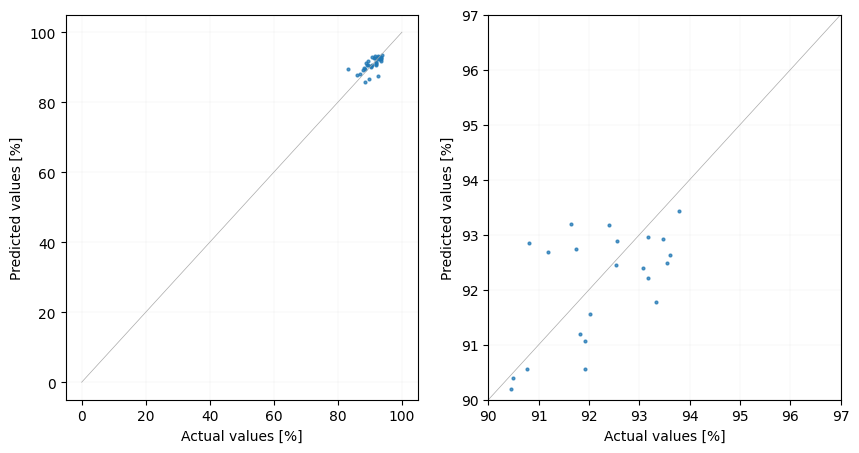

In [10]:
# PLot predictions vs ground truth
scatter_plot2(y_test_scaled, mlp_predictions_scaled)

### Overall comparison

In [66]:
from linear_reg import LRPredictor
from random_forest import RFPredictor
from xgb import XGBPredictor
from mlp import MLPPredictor

In [67]:
X_train = features
y_train = val_accs

X_test = features_test
y_test = val_accs_test
y_test_scaled = NASBench101Dataset.denormalize(y_test) * 100

In [68]:
# Linear regression predictor 
lr_predictor = LRPredictor()
lr_predictor.fit(X_train, y_train)

lr_predictions = lr_predictor.query(X_test)
lr_metrics = lr_predictor.evaluate(X_test, y_test)
lr_predictions_scaled = NASBench101Dataset.denormalize(lr_predictions) * 100

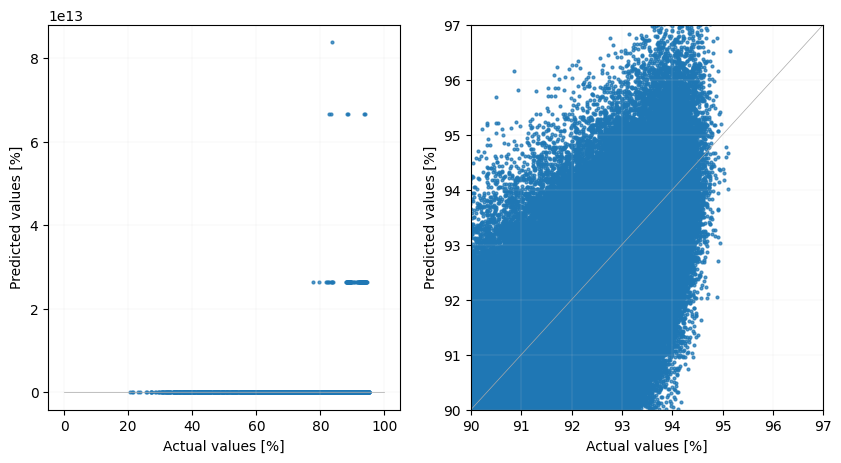

In [69]:
scatter_plot2(y_test_scaled, lr_predictions_scaled)

In [70]:
# Random forest predictor
rf_predictor = RFPredictor()
rf_predictor.fit(X_train, y_train)

rf_predictions = rf_predictor.query(X_test)
rf_metrics = rf_predictor.evaluate(X_test, y_test)
rf_predictions_scaled = NASBench101Dataset.denormalize(rf_predictions) * 100

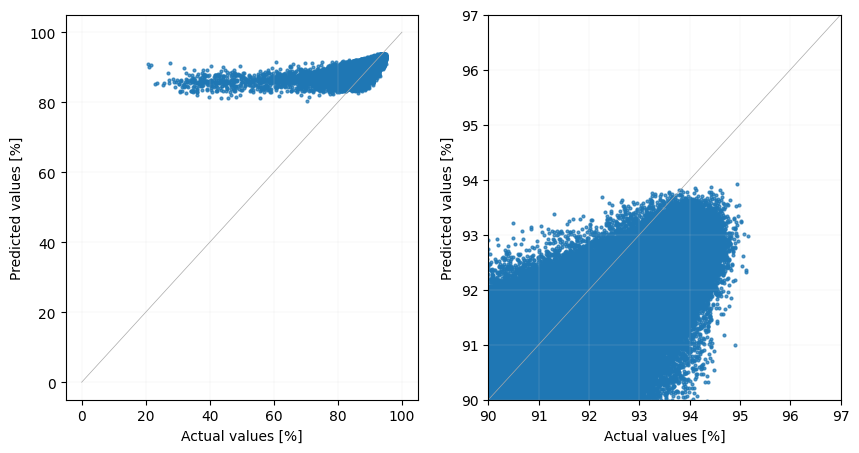

In [71]:
scatter_plot2(y_test_scaled, rf_predictions_scaled)

In [72]:
# XGBoost predictor
xgb_predictor = XGBPredictor()
xgb_predictor.fit(X_train, y_train)

xgb_predictions = xgb_predictor.query(X_test)
xgb_metrics = xgb_predictor.evaluate(X_test, y_test)
xgb_predictions_scaled = NASBench101Dataset.denormalize(xgb_predictions) * 100

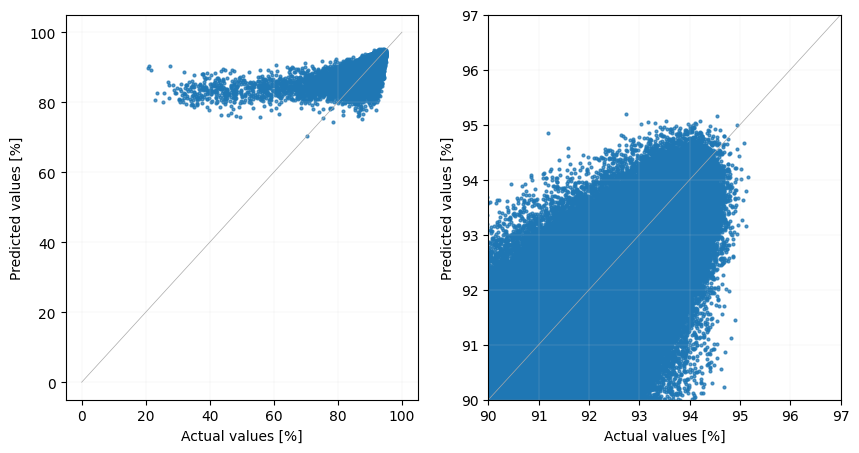

In [74]:
scatter_plot2(y_test_scaled, xgb_predictions_scaled)

In [75]:
# MLP predictor
mlp_predictor = MLPPredictor()
mlp_predictor.fit(X_train, y_train)

mlp_predictions = mlp_predictor.query(X_test)
mlp_metrics = mlp_predictor.evaluate(X_test, y_test)
mlp_predictions_scaled = NASBench101Dataset.denormalize(mlp_predictions) * 100

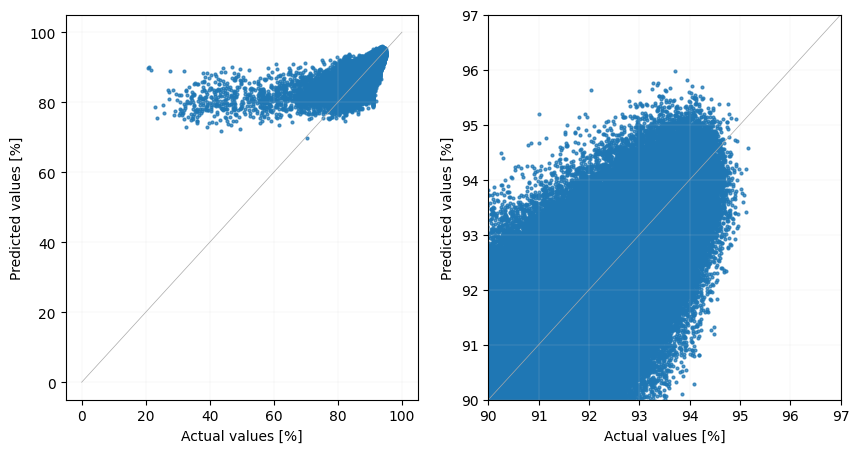

In [76]:
scatter_plot2(y_test_scaled, mlp_predictions_scaled)

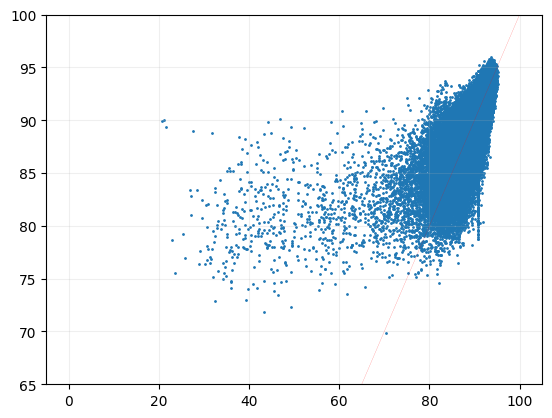

In [86]:
plt.scatter(y_test_scaled, mlp_predictions_scaled, s=1)
plt.grid(alpha=0.2)
plt.plot([0, 100], [0, 100], color="red", linewidth=0.1)
plt.ylim(65, 100)
plt.show()

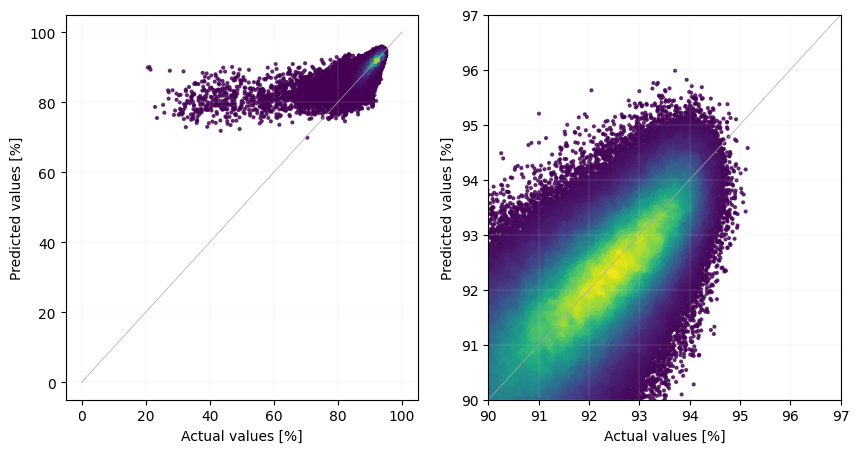

In [87]:
scatter_plot2(y_test_scaled, mlp_predictions_scaled, dense=True)

In [77]:
# Print metrics
print("Linear regression metrics: ", lr_metrics)
print("Random forest metrics: ", rf_metrics)
print("XGBoost metrics: ", xgb_metrics)
print("MLP metrics: ", mlp_metrics)

Linear regression metrics:  {'mae': 2670077231.7694483, 'rmse': 195197170769.92038, 'pearson': -0.003722583042414663, 'spearman': 0.7851536948808993, 'kendalltau': 0.5906832375198957, 'r2_score': -2.5678472129692867e+22}
Random forest metrics:  {'mae': 0.47303842588097056, 'rmse': 0.8758204672719837, 'pearson': 0.7366261821848239, 'spearman': 0.8227883225677064, 'kendalltau': 0.6328481338242169, 'r2_score': 0.4830454970522311}
XGBoost metrics:  {'mae': 0.42245666856038694, 'rmse': 0.8148808375412028, 'pearson': 0.74506342205151, 'spearman': 0.8420197776039794, 'kendalltau': 0.6544541297169159, 'r2_score': 0.5524821600637027}
MLP metrics:  {'mae': 0.428200763041821, 'rmse': 0.7909247620420667, 'pearson': 0.7633173071519216, 'spearman': 0.8474143994505946, 'kendalltau': 0.6580874817304317, 'r2_score': 0.5784078775093736}
